<a href="https://colab.research.google.com/github/duonghung86/Injury-severity-classification/blob/main/VCA_2_1_MLP_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory,cpu_percent
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print('Current system-wide CPU utilization %: ',cpu_percent())
#Remove all warning
import warnings
warnings.filterwarnings("ignore")

Your runtime has 270.0 gigabytes of available RAM

Current system-wide CPU utilization %:  0.0


In [2]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os
#INFO and WARNING messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# Preprocessing
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Machine learning algos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score,confusion_matrix

from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler,NearMiss,EditedNearestNeighbours
# Metrics
from imblearn.metrics import geometric_mean_score
# Tensorflow
import tensorflow as tf
print(tf.__version__)
from tensorflow import feature_column  # for data wrangling
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.metrics import CohenKappa,F1Score
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2.1.0


# Load data

In [3]:
url = 'https://github.com/duonghung86/Injury-severity-classification/blob/main/Prepared%20Texas%202019.zip?raw=true' 
data_path = tf.keras.utils.get_file(origin=url, fname=url.split('/')[-1].split('?')[0], extract=True)
data_path = data_path.replace('%20',' ').replace('.zip','.csv')

In [4]:
# Load data
df = pd.read_csv(data_path)
print(df.shape)
df.head(3)

(949856, 19)


,Prsn_Injry_Sev,Prsn_Age,Prsn_Gndr,Wthr_Cond,Light_Cond,Surf_Cond,Veh_Body_Styl,Prsn_Rest,Prsn_Drg_Rslt,Harm_Evnt,Rural,Crash_Speed_Limit,Road_Algn,Veh_Mod_Year,Weekend,Crash_season,Part_of_day,Collsn_type,Collsn_name
0,0,26,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",33,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
1,0,52,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",19,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
2,0,27,FEMALE,CLEAR,DAYLIGHT,DRY,PICKUP,SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,1,-1,"CURVE, LEVEL",16,1,3,4,SAME DIRECTION,BOTH LEFT TURN


In [5]:
# Let's just use 80% of the total dataset
#df, _ = train_test_split(df, test_size=0.80,stratify = df['Prsn_Injry_Sev'])
#df.shape

In [6]:
y = df['Prsn_Injry_Sev']
print('All target values:')
print(y.value_counts())
X = df.drop(columns=['Prsn_Injry_Sev'])

All target values:
0    792558
1    102409
2     45242
3      7951
4      1696
Name: Prsn_Injry_Sev, dtype: int64


In [7]:
# %% Data wrangling -------------
# Classify variable type
emb_vars, ind_vars, num_vars = [], [], []
for var in X.columns:
    if X[var].dtypes == 'O':
        if len(X[var].unique()) > 5:
            emb_vars.append(var)
        else:
            ind_vars.append(var)
    else:
        num_vars.append(var)
print('Numerical variables are ', num_vars)
print('Categorical variables that have at most 5 categories are ', ind_vars)
print('Categorical variables that have more than 5 categories are ', emb_vars)

# Create feature columns
feature_columns = []
# numeric cols
for header in num_vars:
    feature_columns.append(feature_column.numeric_column(header))
# bucketized cols
# age = feature_column.numeric_column('Prsn_Age')
# age_buckets = feature_column.bucketized_column(age, boundaries=[16, 22, 35, 55, 65])
# feature_columns.append(age_buckets)
# indicator_columns
for col_name in ind_vars:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)
# embedding columns
for col_name in emb_vars:
    emb_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    col_embedding = feature_column.embedding_column(emb_column, dimension=5)
    feature_columns.append(col_embedding)

# Convert all setup into new dataset
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
X = feature_layer(dict(X)).numpy()
print('New shape of the input data set:',X.shape)

Numerical variables are  ['Prsn_Age', 'Rural', 'Crash_Speed_Limit', 'Veh_Mod_Year', 'Weekend', 'Crash_season', 'Part_of_day']
Categorical variables that have at most 5 categories are  ['Prsn_Gndr', 'Prsn_Drg_Rslt', 'Collsn_type']
Categorical variables that have more than 5 categories are  ['Wthr_Cond', 'Light_Cond', 'Surf_Cond', 'Veh_Body_Styl', 'Prsn_Rest', 'Harm_Evnt', 'Road_Algn', 'Collsn_name']
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
New shape of the input data set: (949856, 59)


In [8]:
# %% Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=48)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

# %% standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Training features shape: (607907, 59)
Validation features shape: (151977, 59)
Test features shape: (189972, 59)


In [9]:
# %% Function to compare the prediction and true labels
def get_accs(label, pred_proba, tr_time=0,index=None):
    prediction = pred_proba.argmax(axis=1)
    cm = confusion_matrix(label, prediction)
    length = cm.shape[0]
    num_cases = len(label)
    # global accuracy
    glb_acc = np.trace(cm) / len(label)
    ind_accs = cm / np.sum(cm, axis=1)[:, np.newaxis]
    accs = [ind_accs[i, i] for i in range(length)]
    cols = ['Class {}'.format(i) for i in range(length)]
    # Global accuracy
    accs.append(glb_acc)
    # AUC
    accs.append(roc_auc_score(label, pred_proba,multi_class='ovr'))
    # G-mean
    accs.append(geometric_mean_score(label, prediction, correction=0.001))
    # Average perf
    accs.append(np.mean(accs[-3:]))
    # Training time
    accs.append(np.round(tr_time,3))
    cols = cols + ['Accuracy','AUC','G-mean','OP score','Training Time']

    out = np.array(accs).reshape(1, len(accs))
    return pd.DataFrame(out, columns=cols,index=[index])

## MLP

In [10]:
# Add weights
weights = len(y_train) / (5 * np.bincount(y_train))
cls_wgt = dict(zip(np.arange(5), weights))
cls_wgt

{0: 0.23969347661941065,
 1: 1.8550434079431195,
 2: 4.199122746425364,
 3: 23.891019846728238,
 4: 111.95340699815839}

In [11]:
es = EarlyStopping(monitor='val_accuracy',
                   verbose=1, patience=10, mode='max',
                   restore_best_weights=True)
# Constant
EPOCH = 50
BATCH_SIZE = 2048
VERBOSE = 0

In [12]:
def create_mlp():
    MLP = Sequential([Dense(10,
                           activation='relu',
                           input_dim=X_train.shape[1],
                           ),
                      Dropout(0.5),
                      Dense(5, activation='softmax')])
    MLP.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
               )
    return MLP

In [13]:
rsts = pd.DataFrame()

In [14]:
for i in range(3):
    model = create_mlp()
    start = time.time()
    monitor = model.fit(X_train, y_train.values,
                        callbacks=[es],
                        class_weight = cls_wgt,
                        validation_data=(X_val, y_val.values),
                        batch_size=BATCH_SIZE,
                        verbose=VERBOSE, epochs=EPOCH
                       )
    end = time.time()
    # use the model to make predictions with the test data
    Y_pred = model.predict(X_test)
    rsts = rsts.append(get_accs(y_test.values,Y_pred,end-start,'MLP-Weight-'+str(i)))
rsts

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,OP score,Training Time
MLP-Weight-0,0.518850,0.418611,0.146536,0.294340,0.743363,0.488830,0.718106,0.370313,0.525750,23.894
MLP-Weight-1,0.515500,0.422517,0.130401,0.236478,0.775811,0.485261,0.680064,0.349446,0.504924,12.901
MLP-Weight-2,0.559964,0.363490,0.075367,0.200629,0.755162,0.513039,0.648581,0.297340,0.486320,10.626


# ROS

In [15]:
for i in range(3):
    start = time.time()
    X_res, y_res = RandomOverSampler().fit_resample(X_train, y_train)
    end = time.time()
    res_time = end - start
    print(i)
    print('Resampled dataset shape %s' % Counter(y_res))
    print('resampling time is {0:.2f} seconds'.format(res_time))
    
    model = create_mlp()
    start = time.time()
    monitor = model.fit(X_res, y_res.values,
                        callbacks=[es],
                        validation_data=(X_val, y_val.values),
                        batch_size=BATCH_SIZE,
                        verbose=VERBOSE, epochs=EPOCH
                       )
    end = time.time()
    # use the model to make predictions with the test data
    Y_pred = model.predict(X_test)
    result = get_accs(y_test.values,Y_pred,end-start,'MLP-ROS-'+str(i))
    result['Res_time'] = res_time
    print(result.iloc[:,5:])
    rsts = rsts.append(result)
print(rsts.iloc[:,5:])

0
Resampled dataset shape Counter({1: 507237, 0: 507237, 2: 507237, 4: 507237, 3: 507237})
resampling time is 0.61 seconds
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
           Accuracy       AUC    G-mean  OP score  Training Time  Res_time
MLP-ROS-0  0.498237  0.707332  0.364948  0.523505         62.869  0.607908
1
Resampled dataset shape Counter({1: 507237, 0: 507237, 2: 507237, 4: 507237, 3: 507237})
resampling time is 0.63 seconds
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
           Accuracy       AUC    G-mean  OP score  Training Time  Res_time
MLP-ROS-1  0.478523  0.712973  0.366269  0.519255          40.01  0.626015
2
Resampled dataset shape Counter({1: 507237, 0: 507237, 2: 507237, 4: 507237, 3: 507237})
resampling time is 0.62 seconds
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
           Accuracy       AUC    G-mean  OP score  Training Time  Res_time
MLP-

# Oversampling and then undersampling

In [16]:
y_dict = Counter(y_train)
ss = {}
for i in range(2,5):
    ss[i] = y_dict[1]
overs = ['ROS','SMOTE']
unders = ['RUS']
ss

{2: 65541, 3: 65541, 4: 65541}

In [17]:
#rsts = rsts.iloc[:6,:]

In [18]:
for i in range(3):
    for over in overs:
        for under in unders:
            key = over + '2' + under
            print(key)
            if over == 'ROS': 
                res = RandomOverSampler(sampling_strategy=ss)
            else: res = SMOTE(sampling_strategy=ss)
            start = time.time()
            X_res, y_res = res.fit_resample(X_train, y_train)

            res = RandomUnderSampler(sampling_strategy='majority')
            X_res, y_res = res.fit_resample(X_res, y_res)
            end = time.time()
            res_time = end-start
            print('Resampled dataset shape %s' % Counter(y_res))
            print('Resamling time %.2f sec' % (res_time))
            model = create_mlp()
            start = time.time()
            monitor = model.fit(X_res, y_res,
                                callbacks=[es],
                                validation_data=(X_val, y_val.values),
                                batch_size=BATCH_SIZE,
                                verbose=VERBOSE, epochs=EPOCH
                               )
            end = time.time()
            # use the model to make predictions with the test data
            Y_pred = model.predict(X_test)
            result = get_accs(y_test.values,Y_pred,end-start,'MLP-'+key+'-'+str(i))
            result['Res_time'] = res_time
            print(result.iloc[:,5:])
            rsts = rsts.append(result)
rsts.to_csv('VCA_Resample.csv')
print(rsts.iloc[:,5:])

ROS2RUS
Resampled dataset shape Counter({0: 65541, 1: 65541, 2: 65541, 3: 65541, 4: 65541})
Resamling time 0.57 sec
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
               Accuracy       AUC    G-mean  OP score  Training Time  Res_time
MLP-ROS2RUS-0  0.495378  0.681235  0.356659  0.511091          7.481      0.57
SMOTE2RUS
Resampled dataset shape Counter({0: 65541, 1: 65541, 2: 65541, 3: 65541, 4: 65541})
Resamling time 82.80 sec
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
                 Accuracy       AUC    G-mean  OP score  Training Time  \
MLP-SMOTE2RUS-0  0.489598  0.666189  0.329862  0.495216          6.067   

                  Res_time  
MLP-SMOTE2RUS-0  82.799491  
ROS2RUS
Resampled dataset shape Counter({0: 65541, 1: 65541, 2: 65541, 3: 65541, 4: 65541})
Resamling time 0.56 sec
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
               Accuracy       AU

## Under sampling and then over sampling

In [19]:
unders = ['RUS','NearMiss']

In [20]:
#rsts = rsts.iloc[:12,:]

In [21]:
for i in range(3):
    for under in unders:
        for over in overs:
            key = under + '2' + over
            print(key)
            if under == 'RUS': 
                res = RandomUnderSampler(sampling_strategy={0: y_dict[1]})
            else: res = NearMiss(sampling_strategy={0: y_dict[1]}) 
            start = time.time()
            X_res, y_res = res.fit_resample(X_train, y_train)

            if over == 'ROS': 
                res = RandomOverSampler(sampling_strategy='not majority')
            else: res = SMOTE(sampling_strategy='not majority')
            X_res, y_res = res.fit_resample(X_res, y_res)
            end = time.time()
            res_time = end-start
            print('Resampled dataset shape %s' % Counter(y_res))
            print('Resamling time %.2f sec' % (res_time))
            model = create_mlp()
            start = time.time()
            monitor = model.fit(X_res, y_res,
                                callbacks=[es],
                                validation_data=(X_val, y_val.values),
                                batch_size=BATCH_SIZE,
                                verbose=VERBOSE, epochs=EPOCH
                               )
            end = time.time()
            # use the model to make predictions with the test data
            Y_pred = model.predict(X_test)
            result = get_accs(y_test.values,Y_pred,end-start,'MLP-'+key+'-'+str(i))
            result['Res_time'] = res_time
            print(result.iloc[:,5:])
            rsts = rsts.append(result)
rsts.to_csv('VCA_Resample.csv')
print(rsts.iloc[:,5:])

RUS2ROS
Resampled dataset shape Counter({0: 65541, 1: 65541, 2: 65541, 3: 65541, 4: 65541})
Resamling time 0.26 sec
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
               Accuracy       AUC    G-mean  OP score  Training Time  Res_time
MLP-RUS2ROS-0  0.505932  0.663843  0.278213  0.482663          6.034  0.261136
RUS2SMOTE
Resampled dataset shape Counter({0: 65541, 1: 65541, 2: 65541, 3: 65541, 4: 65541})
Resamling time 78.48 sec
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
                 Accuracy       AUC    G-mean  OP score  Training Time  \
MLP-RUS2SMOTE-0  0.496289  0.653159  0.273641  0.474363          6.035   

                 Res_time  
MLP-RUS2SMOTE-0  78.47683  
NearMiss2ROS
Resampled dataset shape Counter({0: 65541, 1: 65541, 2: 65541, 3: 65541, 4: 65541})
Resamling time 41.49 sec
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
                    Accuracy

In [22]:
rsts = rsts.reset_index()
rsts

,index,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,OP score,Training Time,Res_time
0,MLP-Weight-0,0.518850,0.418611,0.146536,0.294340,0.743363,0.488830,0.718106,0.370313,0.525750,23.894,NaN
1,MLP-Weight-1,0.515500,0.422517,0.130401,0.236478,0.775811,0.485261,0.680064,0.349446,0.504924,12.901,NaN
2,MLP-Weight-2,0.559964,0.363490,0.075367,0.200629,0.755162,0.513039,0.648581,0.297340,0.486320,10.626,NaN
3,MLP-ROS-0,0.528004,0.444732,0.118687,0.340881,0.681416,0.498237,0.707332,0.364948,0.523505,62.869,0.607908
4,MLP-ROS-1,0.503848,0.446001,0.126865,0.323899,0.713864,0.478523,0.712973,0.366269,0.519255,40.010,0.626015
5,MLP-ROS-2,0.518150,0.429011,0.144988,0.359119,0.651917,0.489672,0.713202,0.376303,0.526392,56.801,0.617686
6,MLP-ROS2RUS-0,0.530256,0.399766,0.129186,0.277987,0.758112,0.495378,0.681235,0.356659,0.511091,7.481,0.570000
7,MLP-SMOTE2RUS-0,0.530963,0.348843,0.118798,0.227044,0.781711,0.489598,0.666189,0.329862,0.495216,6.067,82.799491
8,MLP-ROS2RUS-1,0.588668,0.243189,0.126202,0.302516,0.533923,0.526899,0.638985,0.311187,0.492357,5.554,0.558241
9,MLP-SMOTE2RUS-1,0.530685,0.432575,0.101227,0.271069,0.764012,0.497894,0.685692,0.343934,0.509173,6.941,78.395252


In [24]:
for i in range(len(rsts['index'])):
    if rsts['index'][i].find('#')!=-1:
        print(rsts['index'][i].replace('#','-'))
        rsts['index'][i]= rsts['index'][i].replace('#','-')
rsts

,index,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,OP score,Training Time,Res_time
0,MLP-Weight-0,0.518850,0.418611,0.146536,0.294340,0.743363,0.488830,0.718106,0.370313,0.525750,23.894,NaN
1,MLP-Weight-1,0.515500,0.422517,0.130401,0.236478,0.775811,0.485261,0.680064,0.349446,0.504924,12.901,NaN
2,MLP-Weight-2,0.559964,0.363490,0.075367,0.200629,0.755162,0.513039,0.648581,0.297340,0.486320,10.626,NaN
3,MLP-ROS-0,0.528004,0.444732,0.118687,0.340881,0.681416,0.498237,0.707332,0.364948,0.523505,62.869,0.607908
4,MLP-ROS-1,0.503848,0.446001,0.126865,0.323899,0.713864,0.478523,0.712973,0.366269,0.519255,40.010,0.626015
5,MLP-ROS-2,0.518150,0.429011,0.144988,0.359119,0.651917,0.489672,0.713202,0.376303,0.526392,56.801,0.617686
6,MLP-ROS2RUS-0,0.530256,0.399766,0.129186,0.277987,0.758112,0.495378,0.681235,0.356659,0.511091,7.481,0.570000
7,MLP-SMOTE2RUS-0,0.530963,0.348843,0.118798,0.227044,0.781711,0.489598,0.666189,0.329862,0.495216,6.067,82.799491
8,MLP-ROS2RUS-1,0.588668,0.243189,0.126202,0.302516,0.533923,0.526899,0.638985,0.311187,0.492357,5.554,0.558241
9,MLP-SMOTE2RUS-1,0.530685,0.432575,0.101227,0.271069,0.764012,0.497894,0.685692,0.343934,0.509173,6.941,78.395252


In [25]:
indexing = rsts['index'].str.split('-',expand=True)
indexing.columns = ['Model', 'Sampler','Trial']

In [26]:
rsts = pd.concat((rsts, indexing),axis =1)
rsts

,index,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,OP score,Training Time,Res_time,Model,Sampler,Trial
0,MLP-Weight-0,0.518850,0.418611,0.146536,0.294340,0.743363,0.488830,0.718106,0.370313,0.525750,23.894,NaN,MLP,Weight,0
1,MLP-Weight-1,0.515500,0.422517,0.130401,0.236478,0.775811,0.485261,0.680064,0.349446,0.504924,12.901,NaN,MLP,Weight,1
2,MLP-Weight-2,0.559964,0.363490,0.075367,0.200629,0.755162,0.513039,0.648581,0.297340,0.486320,10.626,NaN,MLP,Weight,2
3,MLP-ROS-0,0.528004,0.444732,0.118687,0.340881,0.681416,0.498237,0.707332,0.364948,0.523505,62.869,0.607908,MLP,ROS,0
4,MLP-ROS-1,0.503848,0.446001,0.126865,0.323899,0.713864,0.478523,0.712973,0.366269,0.519255,40.010,0.626015,MLP,ROS,1
5,MLP-ROS-2,0.518150,0.429011,0.144988,0.359119,0.651917,0.489672,0.713202,0.376303,0.526392,56.801,0.617686,MLP,ROS,2
6,MLP-ROS2RUS-0,0.530256,0.399766,0.129186,0.277987,0.758112,0.495378,0.681235,0.356659,0.511091,7.481,0.570000,MLP,ROS2RUS,0
7,MLP-SMOTE2RUS-0,0.530963,0.348843,0.118798,0.227044,0.781711,0.489598,0.666189,0.329862,0.495216,6.067,82.799491,MLP,SMOTE2RUS,0
8,MLP-ROS2RUS-1,0.588668,0.243189,0.126202,0.302516,0.533923,0.526899,0.638985,0.311187,0.492357,5.554,0.558241,MLP,ROS2RUS,1
9,MLP-SMOTE2RUS-1,0.530685,0.432575,0.101227,0.271069,0.764012,0.497894,0.685692,0.343934,0.509173,6.941,78.395252,MLP,SMOTE2RUS,1


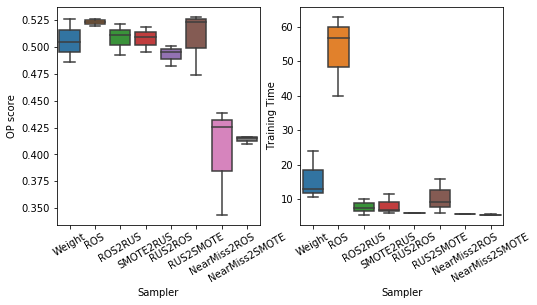

In [27]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.boxplot(data=rsts, x='Sampler',y='OP score')
plt.xticks(rotation=30)
plt.subplot(1,2,2)
sns.boxplot(data=rsts, x='Sampler',y='Training Time')
plt.xticks(rotation=30)
plt.savefig('Hybrid_samplers.png',bbox_inches='tight',dpi=200)
plt.show()

In [28]:
hs_results = rsts.iloc[6:,:]
hs_results

,index,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,OP score,Training Time,Res_time,Model,Sampler,Trial
6,MLP-ROS2RUS-0,0.530256,0.399766,0.129186,0.277987,0.758112,0.495378,0.681235,0.356659,0.511091,7.481,0.570000,MLP,ROS2RUS,0
7,MLP-SMOTE2RUS-0,0.530963,0.348843,0.118798,0.227044,0.781711,0.489598,0.666189,0.329862,0.495216,6.067,82.799491,MLP,SMOTE2RUS,0
8,MLP-ROS2RUS-1,0.588668,0.243189,0.126202,0.302516,0.533923,0.526899,0.638985,0.311187,0.492357,5.554,0.558241,MLP,ROS2RUS,1
9,MLP-SMOTE2RUS-1,0.530685,0.432575,0.101227,0.271069,0.764012,0.497894,0.685692,0.343934,0.509173,6.941,78.395252,MLP,SMOTE2RUS,1
10,MLP-ROS2RUS-2,0.528105,0.377405,0.188529,0.284906,0.719764,0.493989,0.691469,0.377885,0.521114,10.193,0.558328,MLP,ROS2RUS,2
11,MLP-SMOTE2RUS-2,0.514106,0.410702,0.147751,0.284277,0.749263,0.484003,0.704460,0.366857,0.518440,11.641,79.350965,MLP,SMOTE2RUS,2
12,MLP-RUS2ROS-0,0.545069,0.425740,0.041662,0.221384,0.778761,0.505932,0.663843,0.278213,0.482663,6.034,0.261136,MLP,RUS2ROS,0
13,MLP-RUS2SMOTE-0,0.533335,0.427644,0.033484,0.266038,0.755162,0.496289,0.653159,0.273641,0.474363,6.035,78.476830,MLP,RUS2SMOTE,0
14,MLP-NearMiss2ROS-0,0.486935,0.117518,0.182783,0.291824,0.687316,0.431343,0.593938,0.291311,0.438864,5.685,41.494164,MLP,NearMiss2ROS,0
15,MLP-NearMiss2SMOTE-0,0.456079,0.273167,0.036910,0.341509,0.569322,0.415635,0.586837,0.245626,0.416033,5.583,120.388947,MLP,NearMiss2SMOTE,0


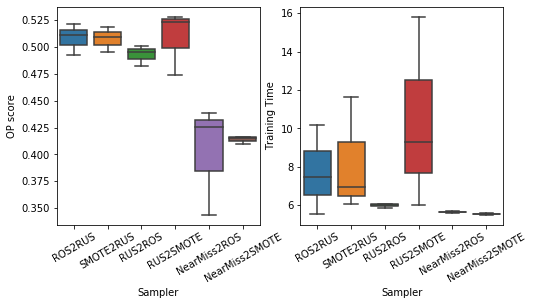

In [34]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.boxplot(data=hs_results, x='Sampler',y='OP score')
plt.xticks(rotation=30)
plt.subplot(1,2,2)
sns.boxplot(data=hs_results, x='Sampler',y='Training Time')
plt.xticks(rotation=30)
plt.savefig('Hybrid_samplers.png',bbox_inches='tight',dpi=200)
plt.show()

In [30]:
hs_results['Total_time'] = hs_results['Res_time']+hs_results['Training Time']

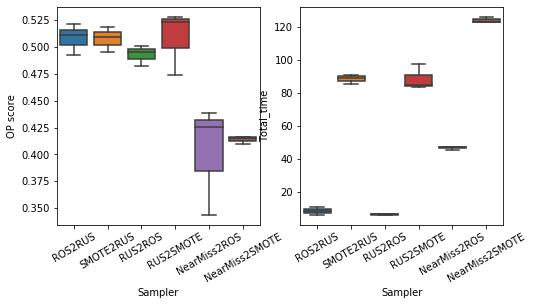

In [31]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.boxplot(data=hs_results, x='Sampler',y='OP score')
plt.xticks(rotation=30)
plt.subplot(1,2,2)
sns.boxplot(data=hs_results, x='Sampler',y='Total_time')
plt.xticks(rotation=30)
plt.savefig('Hybrid_samplers.png',bbox_inches='tight',dpi=200)
plt.show()

In [32]:
rsts.to_csv('VCA_Resample1.csv')